In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barc-intern-1/OdettedataML1.csv
/kaggle/input/barc-intern-1/japan2.csv
/kaggle/input/barc-intern-1/final-data.csv


In [4]:
!pip install pycaret -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 13.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 85.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 103.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 101.1 MB/s eta 0:00:0000:010:01

In [5]:
import numpy as np
import pandas as pd
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
from sklearn import set_config
set_config(display='text')
import optuna
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from datetime import datetime


In [ ]:
df3 = pd.read_csv("/kaggle/input/barc-intern-1/final-data.csv")

# Drop the target column to prepare for normalization
df4 = df3.drop('DeltaYS', axis=1)

In [7]:
# Normalize the features
df_norm2 = (df4 - df4.min()) / (df4.max() - df4.min())
df_norm2 = pd.concat((df_norm2, df3.DeltaT), axis=1)


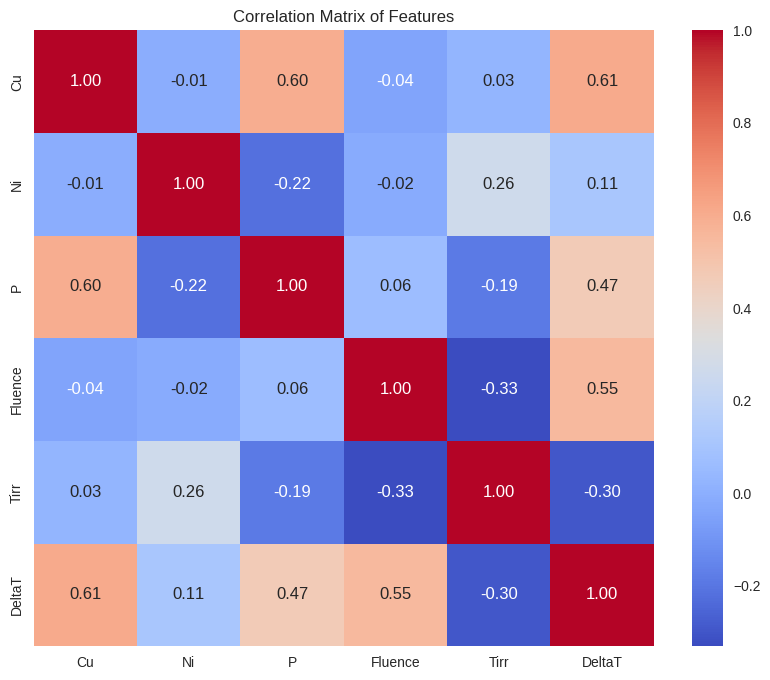

In [8]:

# Display the correlation matrix
correlation_matrix = df3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.savefig('correlation_matrix.png')

In [9]:
# Set up PyCaret with cross-validation
# Using 5-fold cross-validation to ensure robust model evaluation
reg_setup = setup(data=df_norm2, target='DeltaT', session_id=123, 
                 normalize=False,  # Already normalized
                 train_size=0.8,
                 fold=5,  # 5-fold cross-validation
                 verbose=False)

In [10]:
best_model = compare_models(sort='R2', n_select=1, verbose=True)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,6.6003,88.5477,9.3381,0.8707,0.4539,0.4113,0.4420
gbr,Gradient Boosting Regressor,7.4613,102.1118,10.0543,0.8522,0.4753,0.4409,0.0380
et,Extra Trees Regressor,6.5338,102.1861,9.9975,0.8505,0.4641,0.3993,0.0820
rf,Random Forest Regressor,7.7610,114.7786,10.6077,0.8334,0.4836,0.4562,0.1000
xgboost,Extreme Gradient Boosting,6.9468,117.2842,10.6930,0.8292,0.4890,0.4062,0.0480
ada,AdaBoost Regressor,9.4621,138.6055,11.7405,0.7997,0.5344,0.5831,0.0520
lightgbm,Light Gradient Boosting Machine,9.1901,159.3089,12.5694,0.7718,0.5116,0.4877,5.6460
dt,Decision Tree Regressor,8.3263,160.9393,12.3483,0.7617,0.5725,0.4534,0.0120
lr,Linear Regression,10.7447,186.5925,13.5982,0.7321,0.5995,0.5939,1.2440
lar,Least Angle Regression,10.7447,186.5924,13.5982,0.7321,0.5995,0.5939,0.0120


In [11]:
# Tune the best model to improve R2 score
tuned_model = tune_model(best_model, 
                        optimize='R2', 
                        n_iter=50,  # Increase iterations for better tuning
                        verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0846,87.6591,9.3626,0.8950,0.3905,0.4015
1,5.7590,90.3195,9.5037,0.8820,0.4588,0.6090
2,4.7697,48.0254,6.9300,0.9354,0.4517,0.1977
3,5.7764,80.4363,8.9686,0.8619,0.6005,0.4092
4,7.5112,131.8362,11.4820,0.7886,0.3162,0.3202
Mean,6.1802,87.6553,9.2494,0.8726,0.4435,0.3875
Std,0.9919,26.7645,1.4505,0.0484,0.0938,0.1344


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [12]:
# Finalize the tuned model
final_model = finalize_model(tuned_model)

# Make predictions on the hold-out test set
predictions = predict_model(final_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.8705,1.8939,1.3762,0.9981,0.1634,0.0647


In [13]:
X = df_norm2.drop('DeltaT', axis=1)
y = df_norm2['DeltaT']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [14]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

In [15]:
train_r2_score = r2_score(y_train, y_train_pred)
test_r2_score = r2_score(y_test, y_test_pred)

In [19]:
import pandas as pd


if hasattr(final_model, "get_params"):
    params = final_model.get_params()
elif hasattr(final_model, "get_all_params"):
    params = final_model.get_all_params()
else:
    raise AttributeError("Model parameters could not be extracted.")


param_df = pd.DataFrame(list(params.items()), columns=["Parameter", "Value"])


from IPython.display import display
display(param_df.style.set_properties(**{
    'background-color': '#f9f9f9',
    'color': 'black',
    'border-color': 'gray'
}).set_table_styles([{
    'selector': 'thead th',
    'props': [('background-color', '#40466e'), ('color', 'white'), ('font-size', '14px')]
}]).set_caption("Model Parameters"))


,Parameter,Value
0,memory,Memory(location=None)
1,steps,"[('numerical_imputer', TransformerWrapper(include=['Cu', 'Ni', 'P', 'Fluence', 'Tirr'], transformer=SimpleImputer())), ('categorical_imputer', TransformerWrapper(include=[], transformer=SimpleImputer(strategy='most_frequent'))), ('actual_estimator', )]"
2,verbose,False
3,numerical_imputer,"TransformerWrapper(include=['Cu', 'Ni', 'P', 'Fluence', 'Tirr'], transformer=SimpleImputer())"
4,categorical_imputer,"TransformerWrapper(include=[], transformer=SimpleImputer(strategy='most_frequent'))"
5,actual_estimator,
6,numerical_imputer__exclude,None
7,numerical_imputer__include,"['Cu', 'Ni', 'P', 'Fluence', 'Tirr']"
8,numerical_imputer__transformer__add_indicator,False
9,numerical_imputer__transformer__copy,True


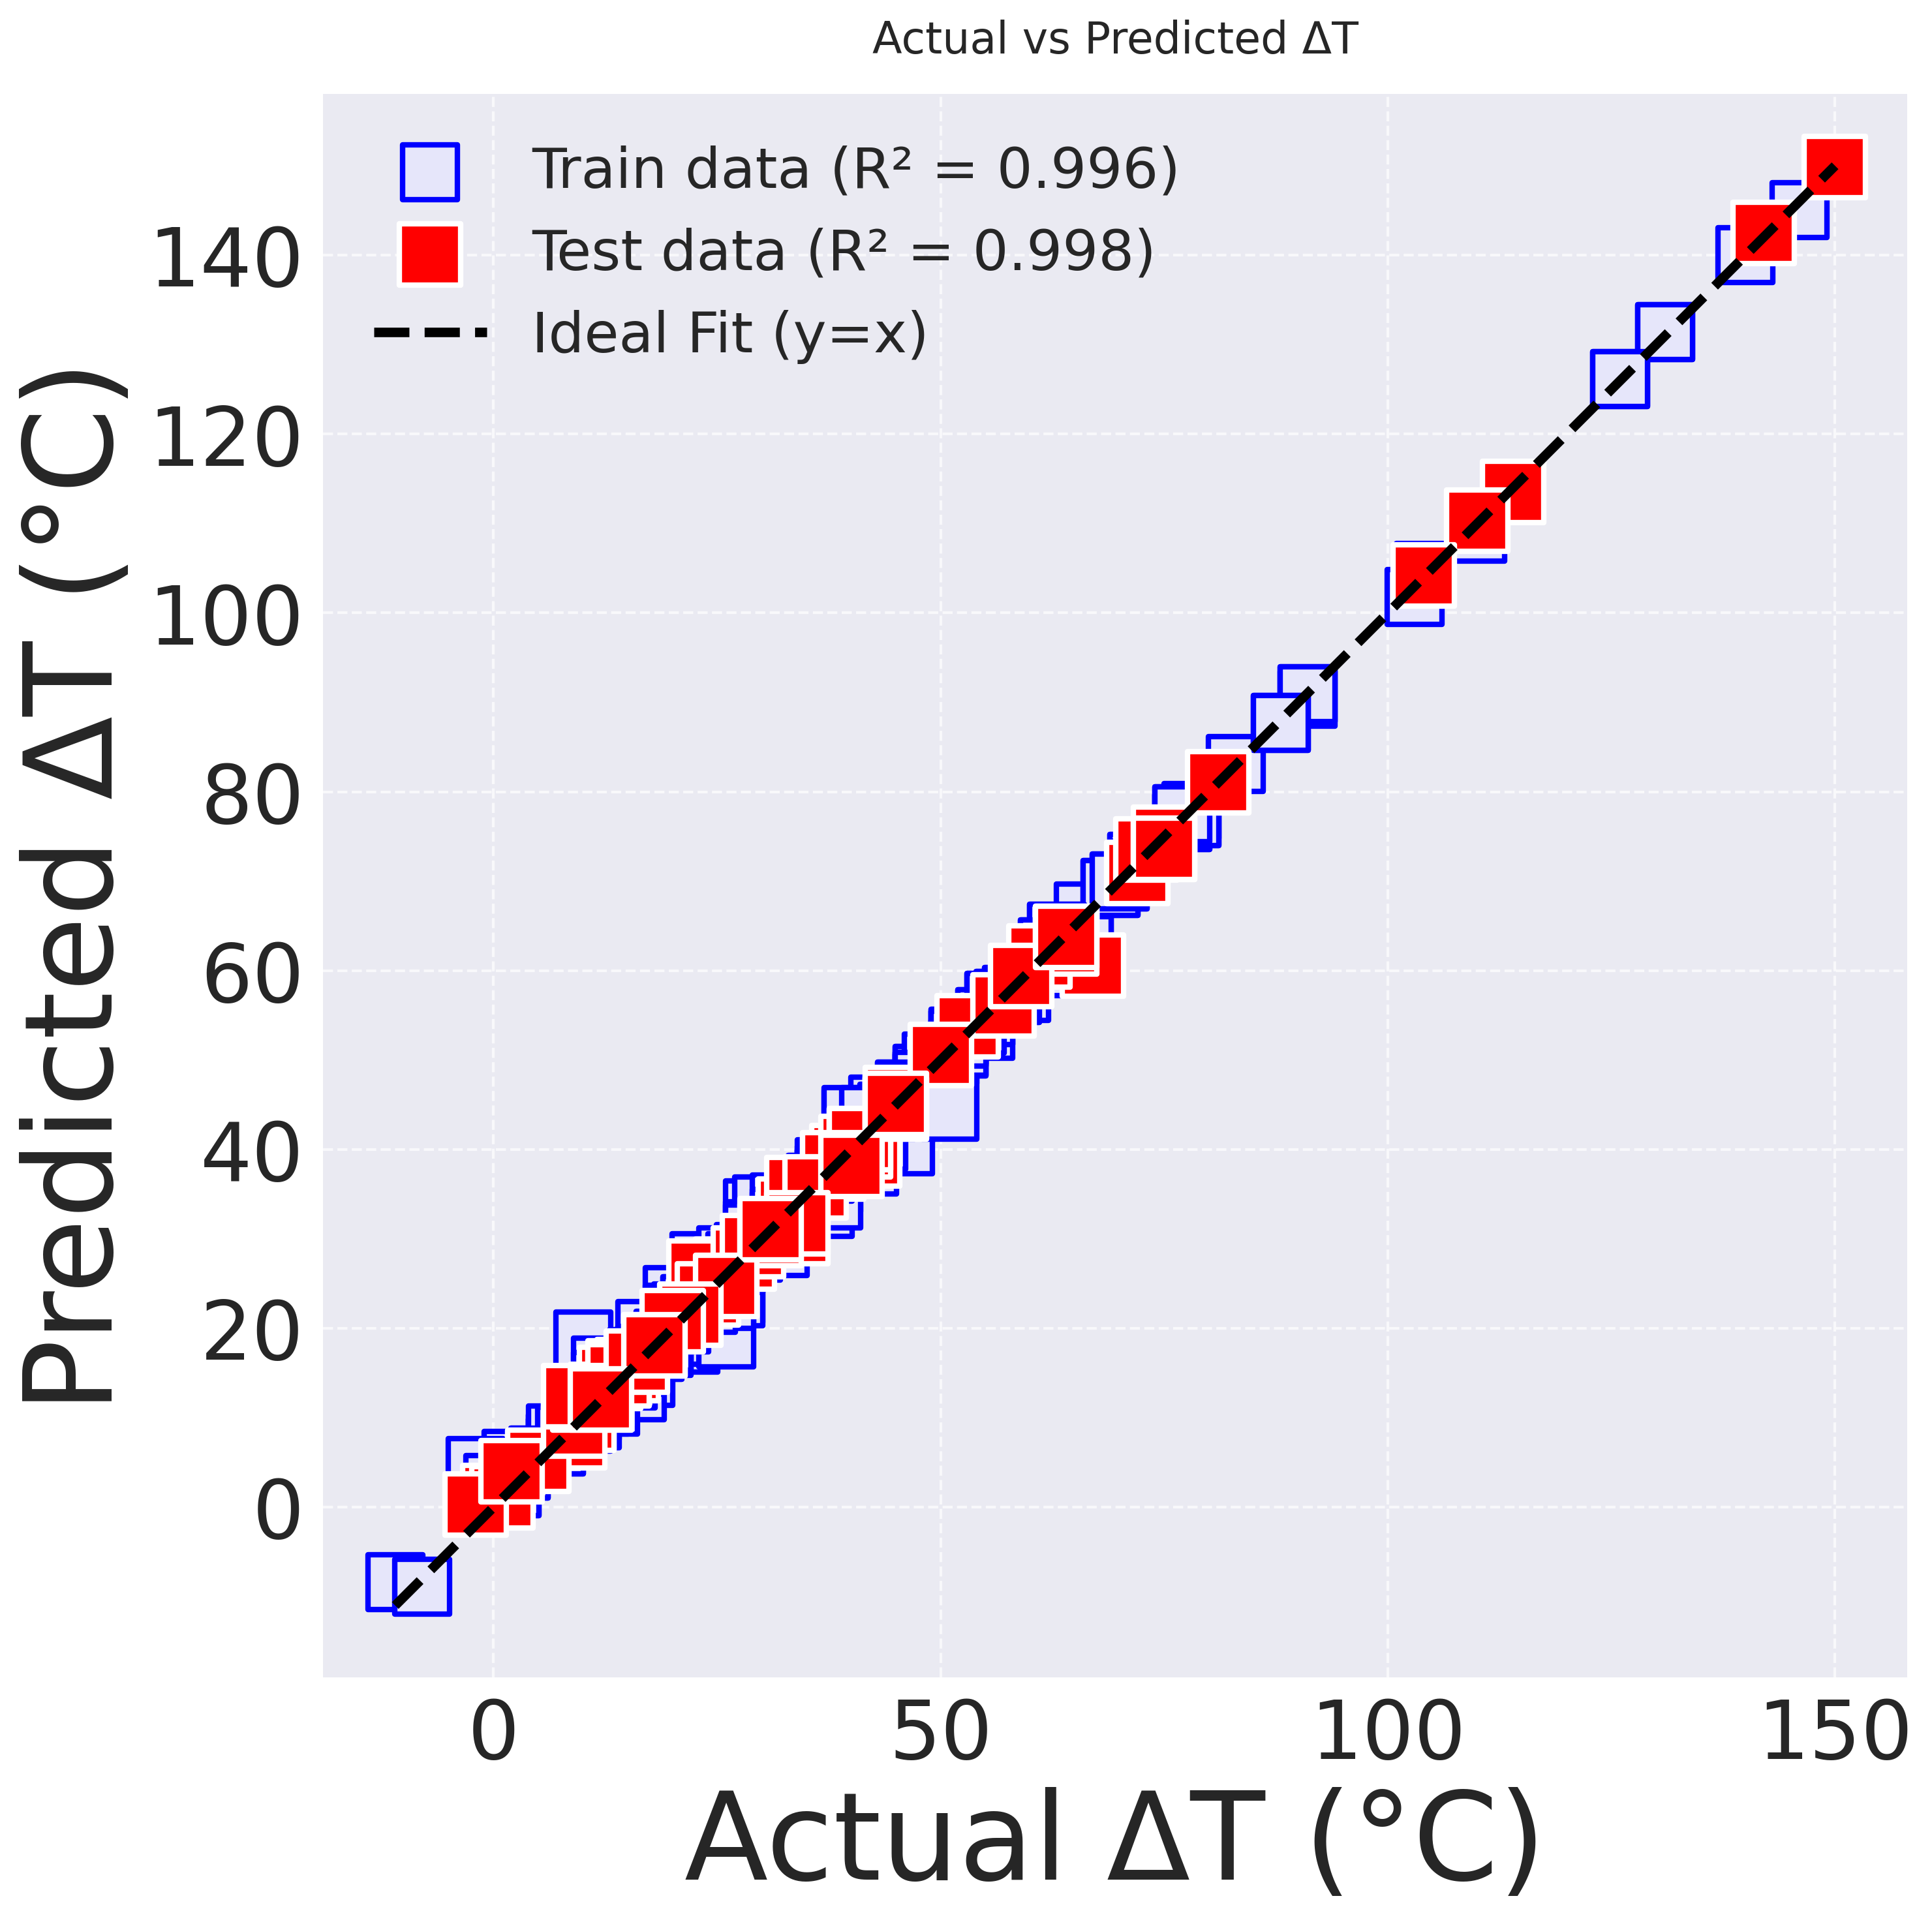

In [16]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'Times New Roman',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False,
})



fig, ax = plt.subplots(figsize=(10, 10))  # Match the size from the example
ax.scatter(y_train, y_train_pred, s=400, marker='s', linewidth=2, edgecolors="blue", 
           color="lavender", label=f'Train data (R² = {train_r2_score:.3f})')
ax.scatter(y_test, y_test_pred, s=500, marker='s', linewidth=2, edgecolors="white", 
           color="red", label=f'Test data (R² = {test_r2_score:.3f})')
min_val = min(y.min(), min(y_train_pred.min(), y_test_pred.min()))
max_val = max(y.max(), max(y_train_pred.max(), y_test_pred.max()))
xl = yl = [min_val, max_val]
ax.plot(xl, yl, linestyle='dashed', color='black', linewidth=3.5, label='Ideal Fit (y=x)')
# Customize labels, legend, and ticks
ax.set_xlabel('Actual ΔT (°C)', fontsize=45)
ax.set_ylabel('Predicted ΔT (°C)', fontsize=45)
ax.set_title('Actual vs Predicted ΔT', fontsize=16, pad=15)
ax.legend(loc='upper left', fontsize='xx-large', facecolor='w', edgecolor='black')
ax.tick_params(axis='both', which='major', labelsize=30)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()

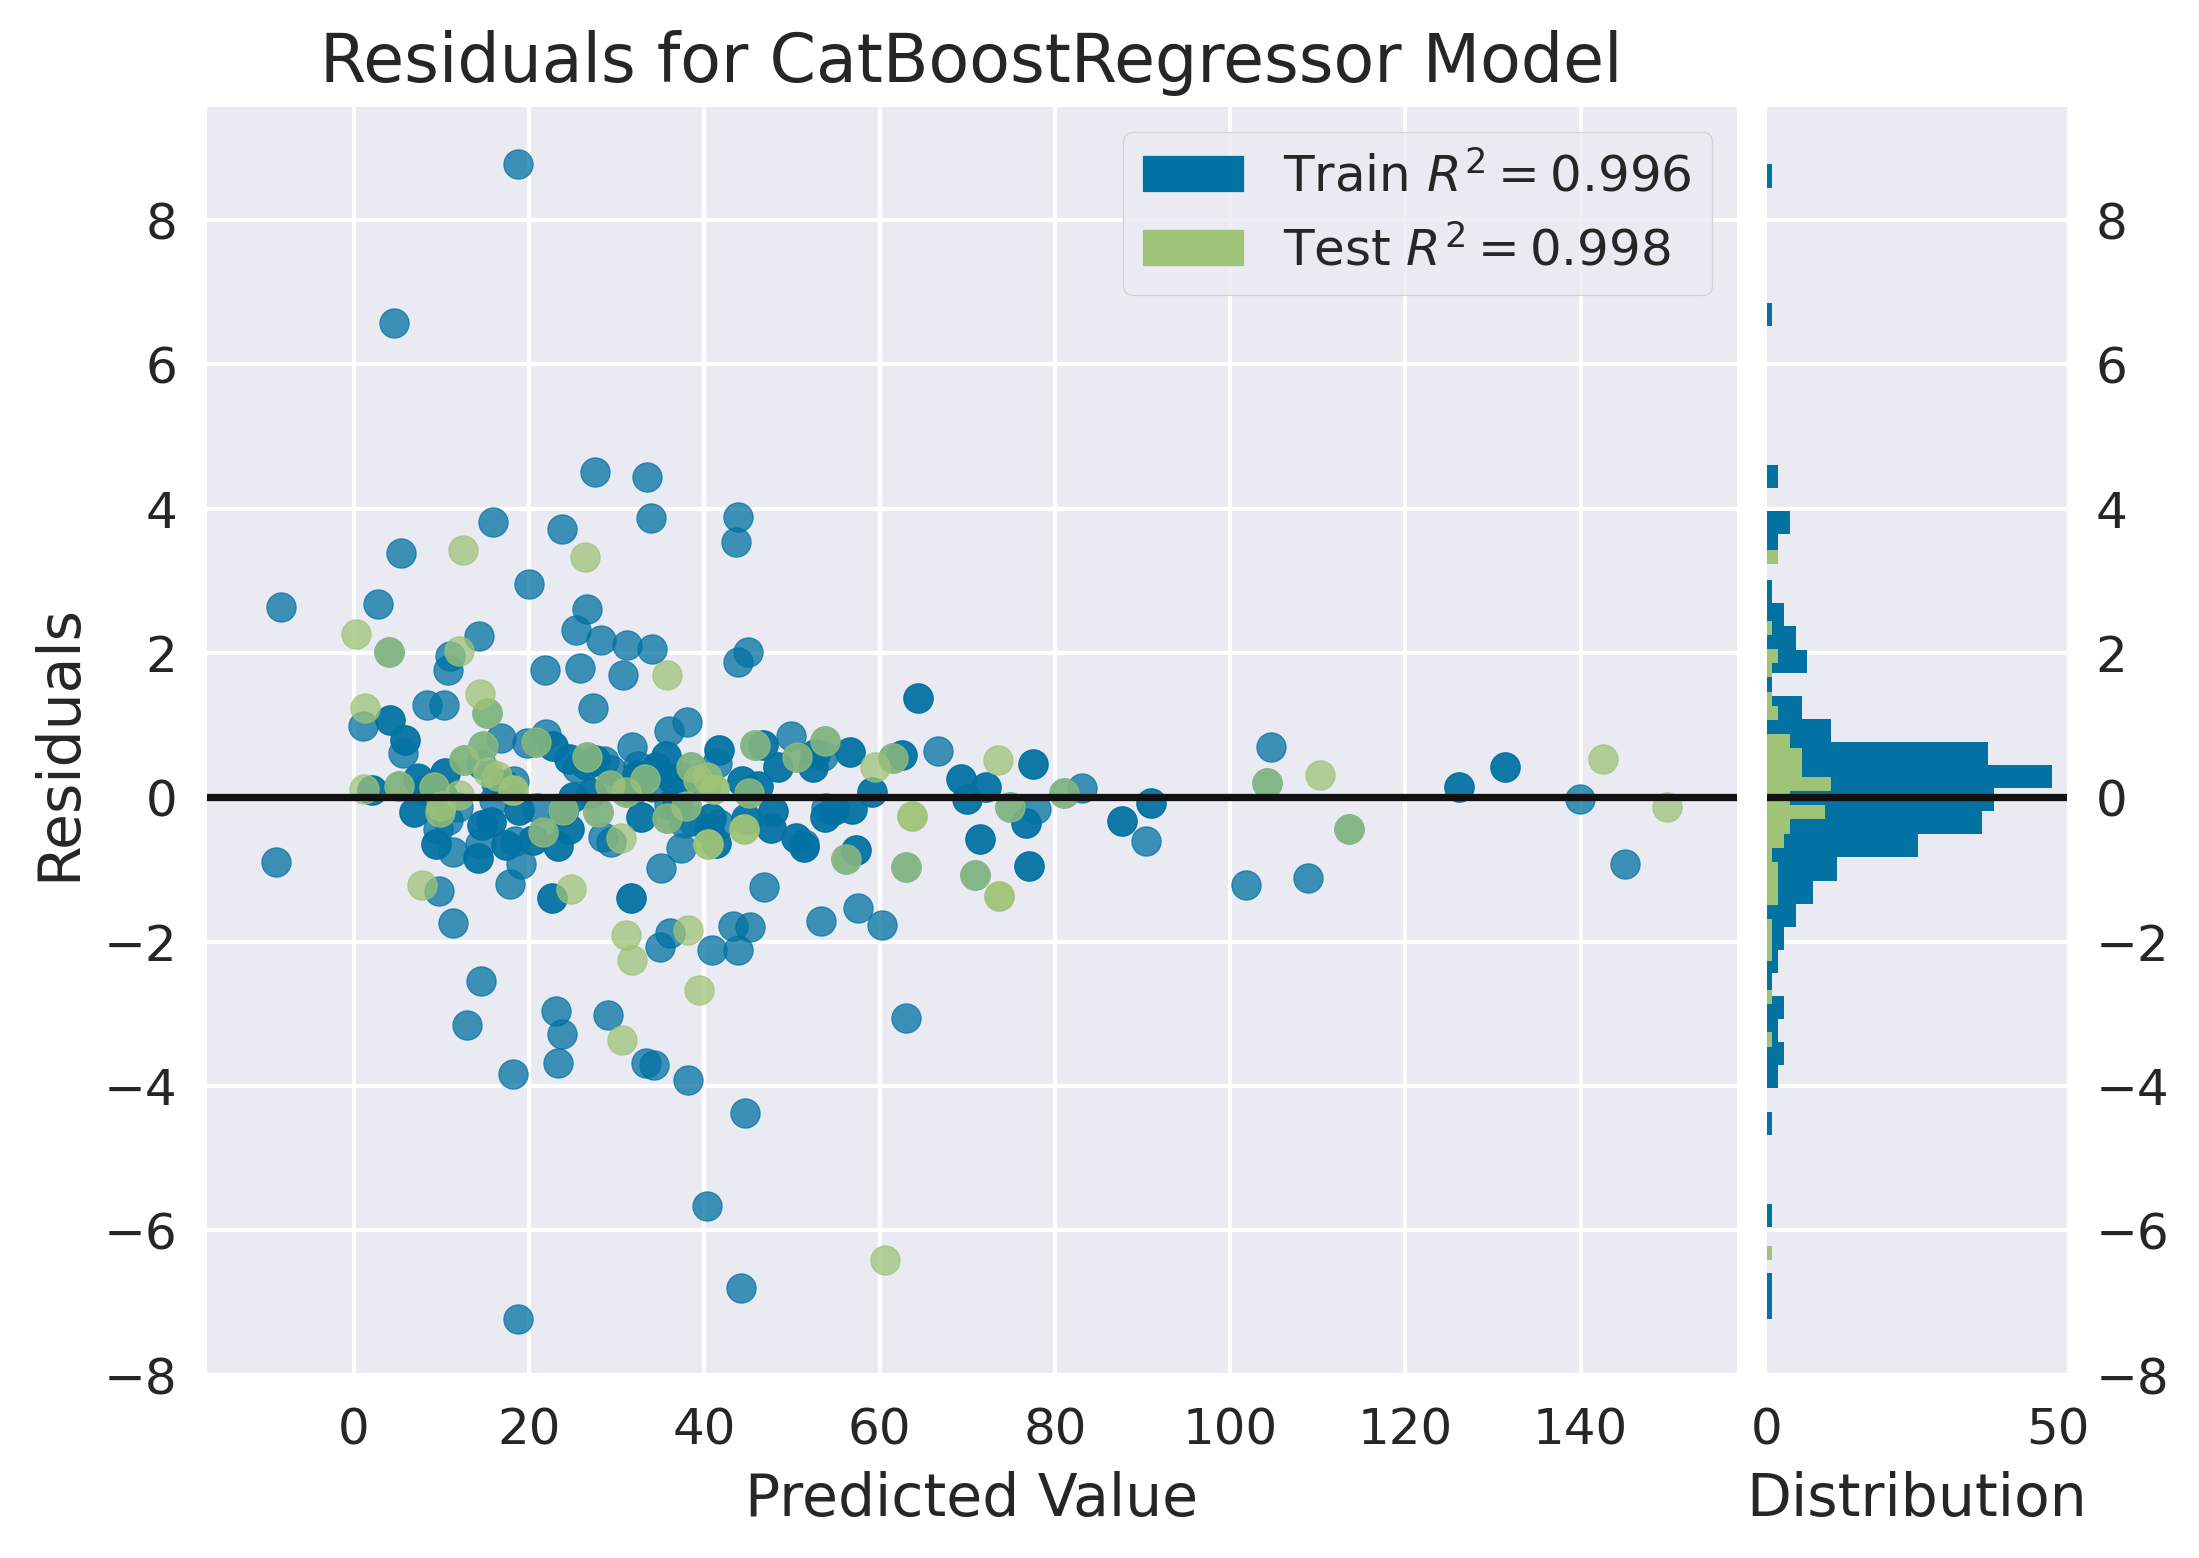

In [17]:
plot_model(final_model)

TypeError: Axes.text() got multiple values for argument 'x'

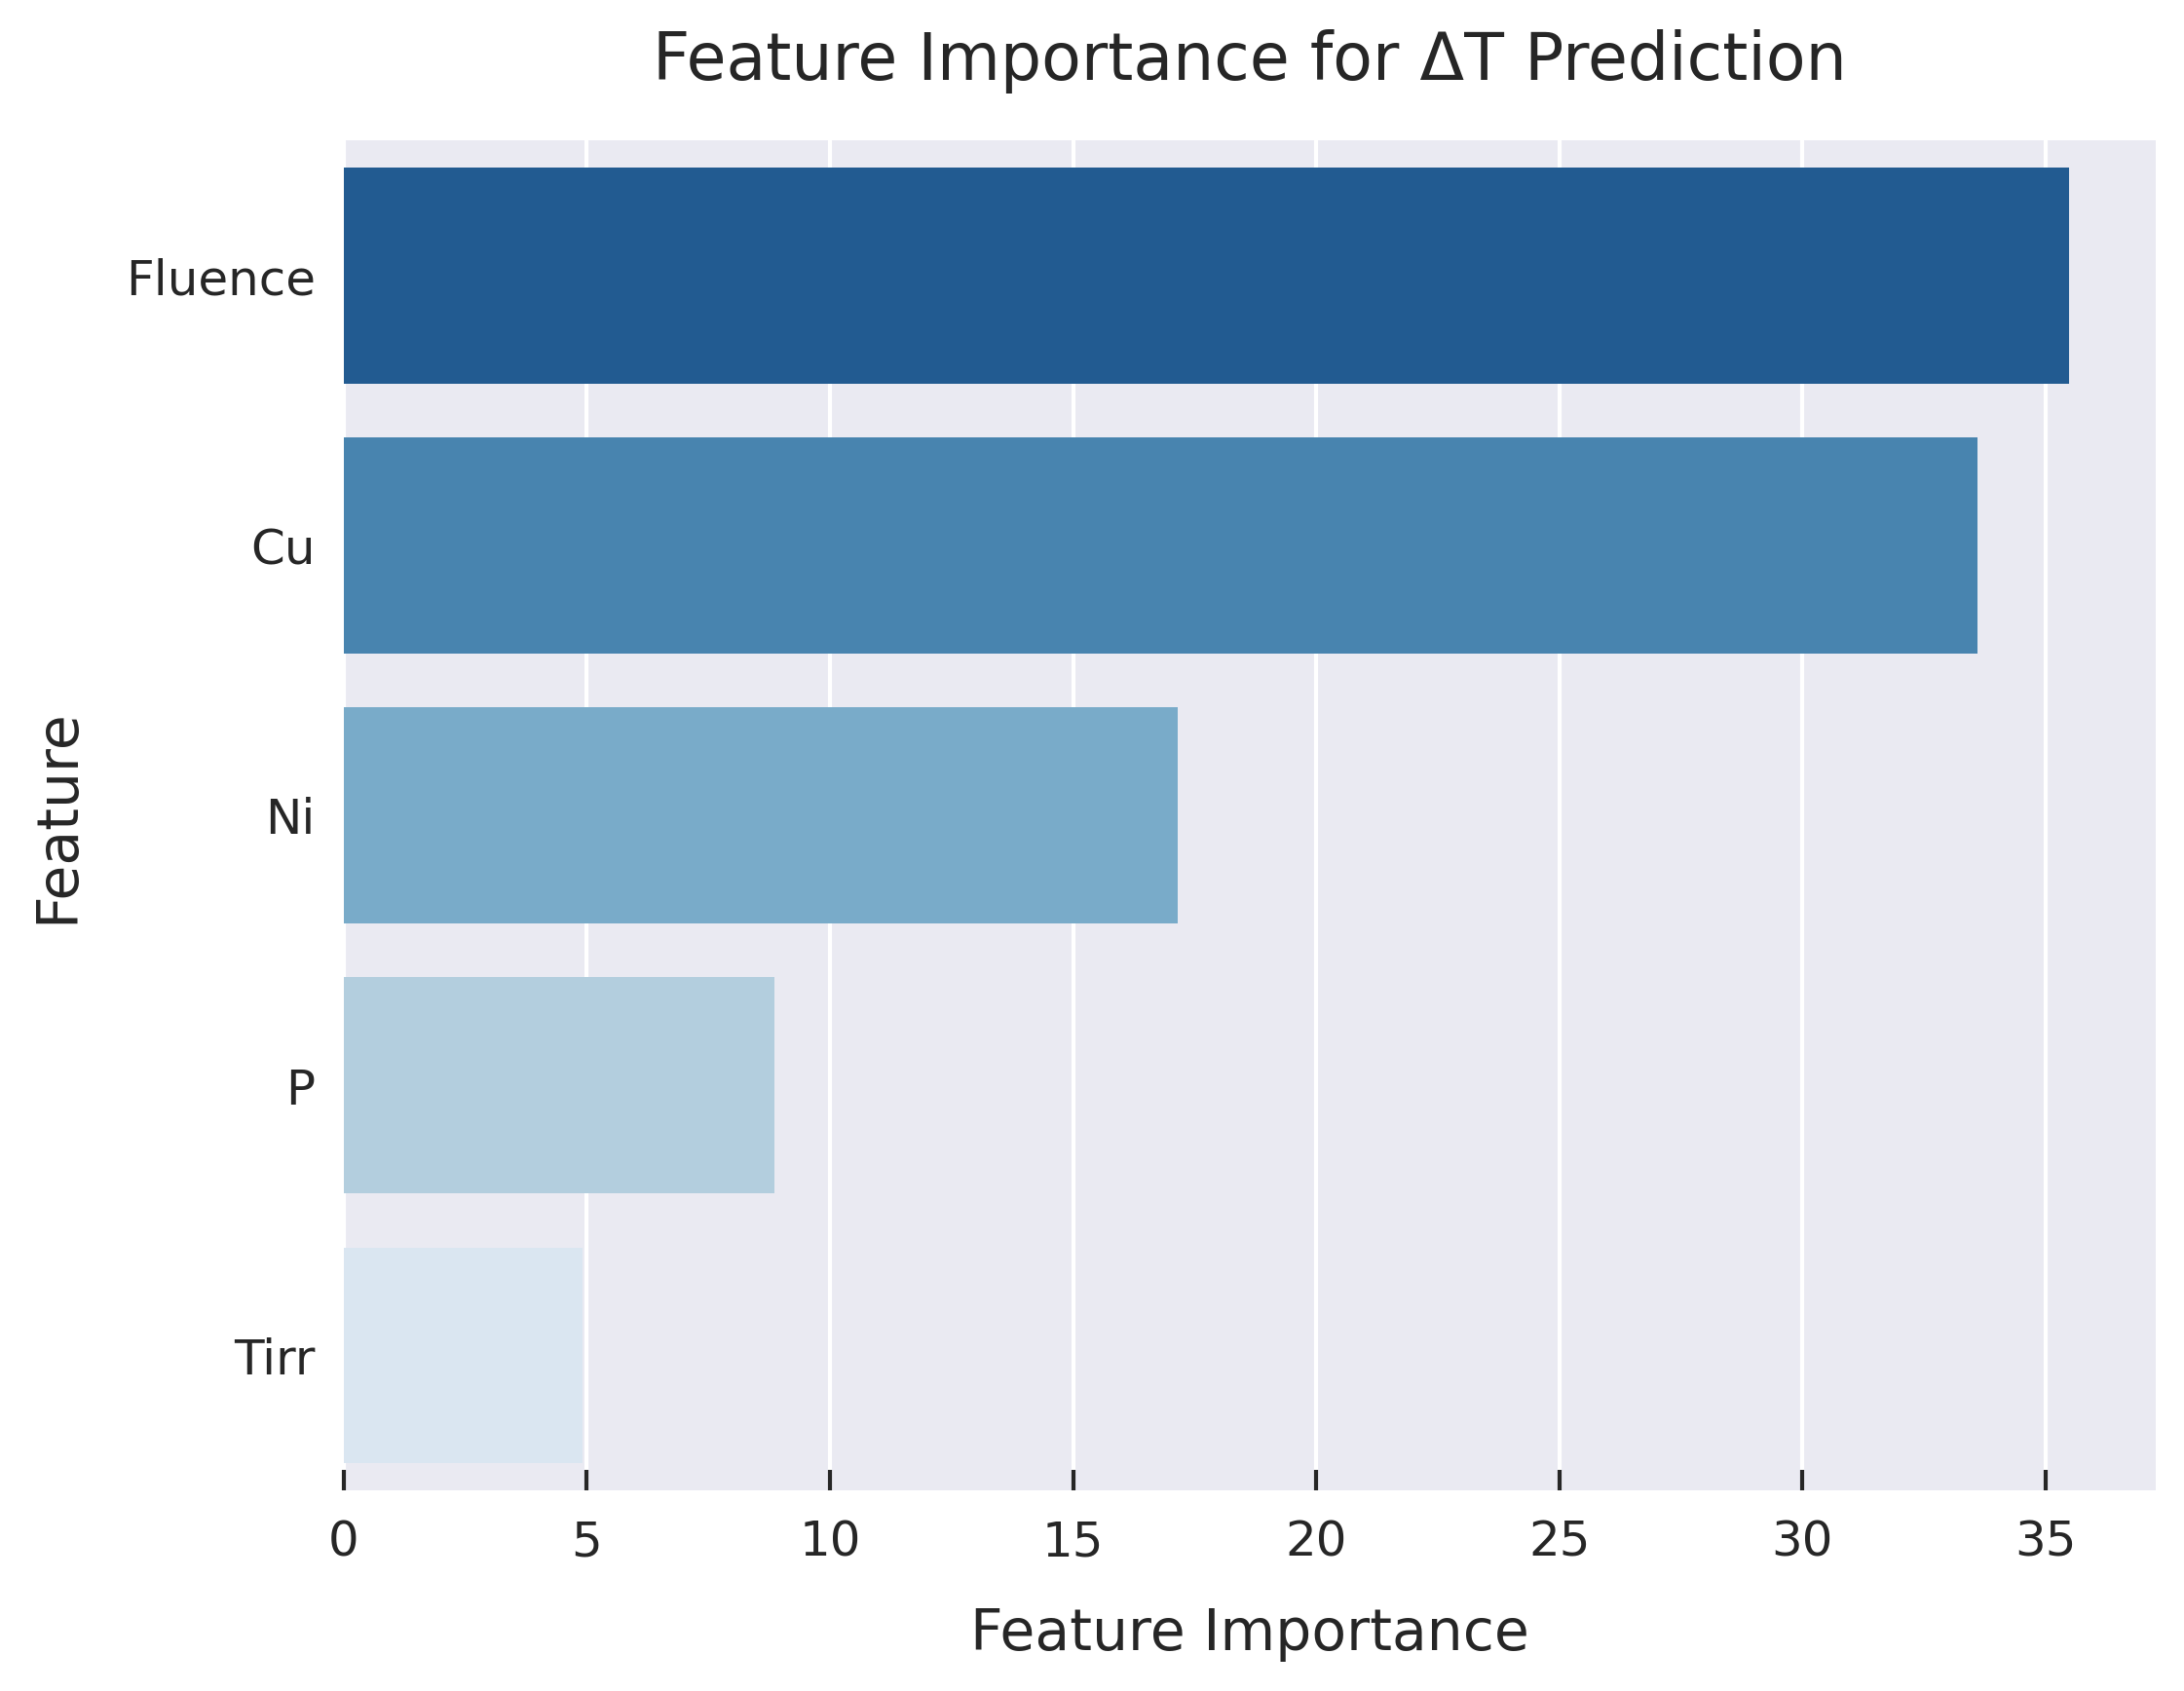

In [18]:
if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    feature_names = df_norm2.drop('DeltaT', axis=1).columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r', ax=ax)
    ax.set_xlabel('Feature Importance', fontsize=14, labelpad=10)
    ax.set_ylabel('Feature', fontsize=14, labelpad=10)
    ax.set_title('Feature Importance for ΔT Prediction', fontsize=16, pad=15)
    ax.tick_params(axis='both', which='major', direction='in', length=5)
    for i, v in enumerate(importance_df['Importance']):
        ax.text(v, i, f'{v:.2f}', va='center', ha='left', fontsize=10, color='black', x=v + 0.02)
    plt.tight_layout()
    plt.savefig('feature_importance_professional.png', bbox_inches='tight', dpi=300)
else:
    print("Feature importance not available for this model.")

In [20]:
!pip install shap -q

In [21]:
import shap
pd.set_option('display.max_columns', None)
shap.initjs()


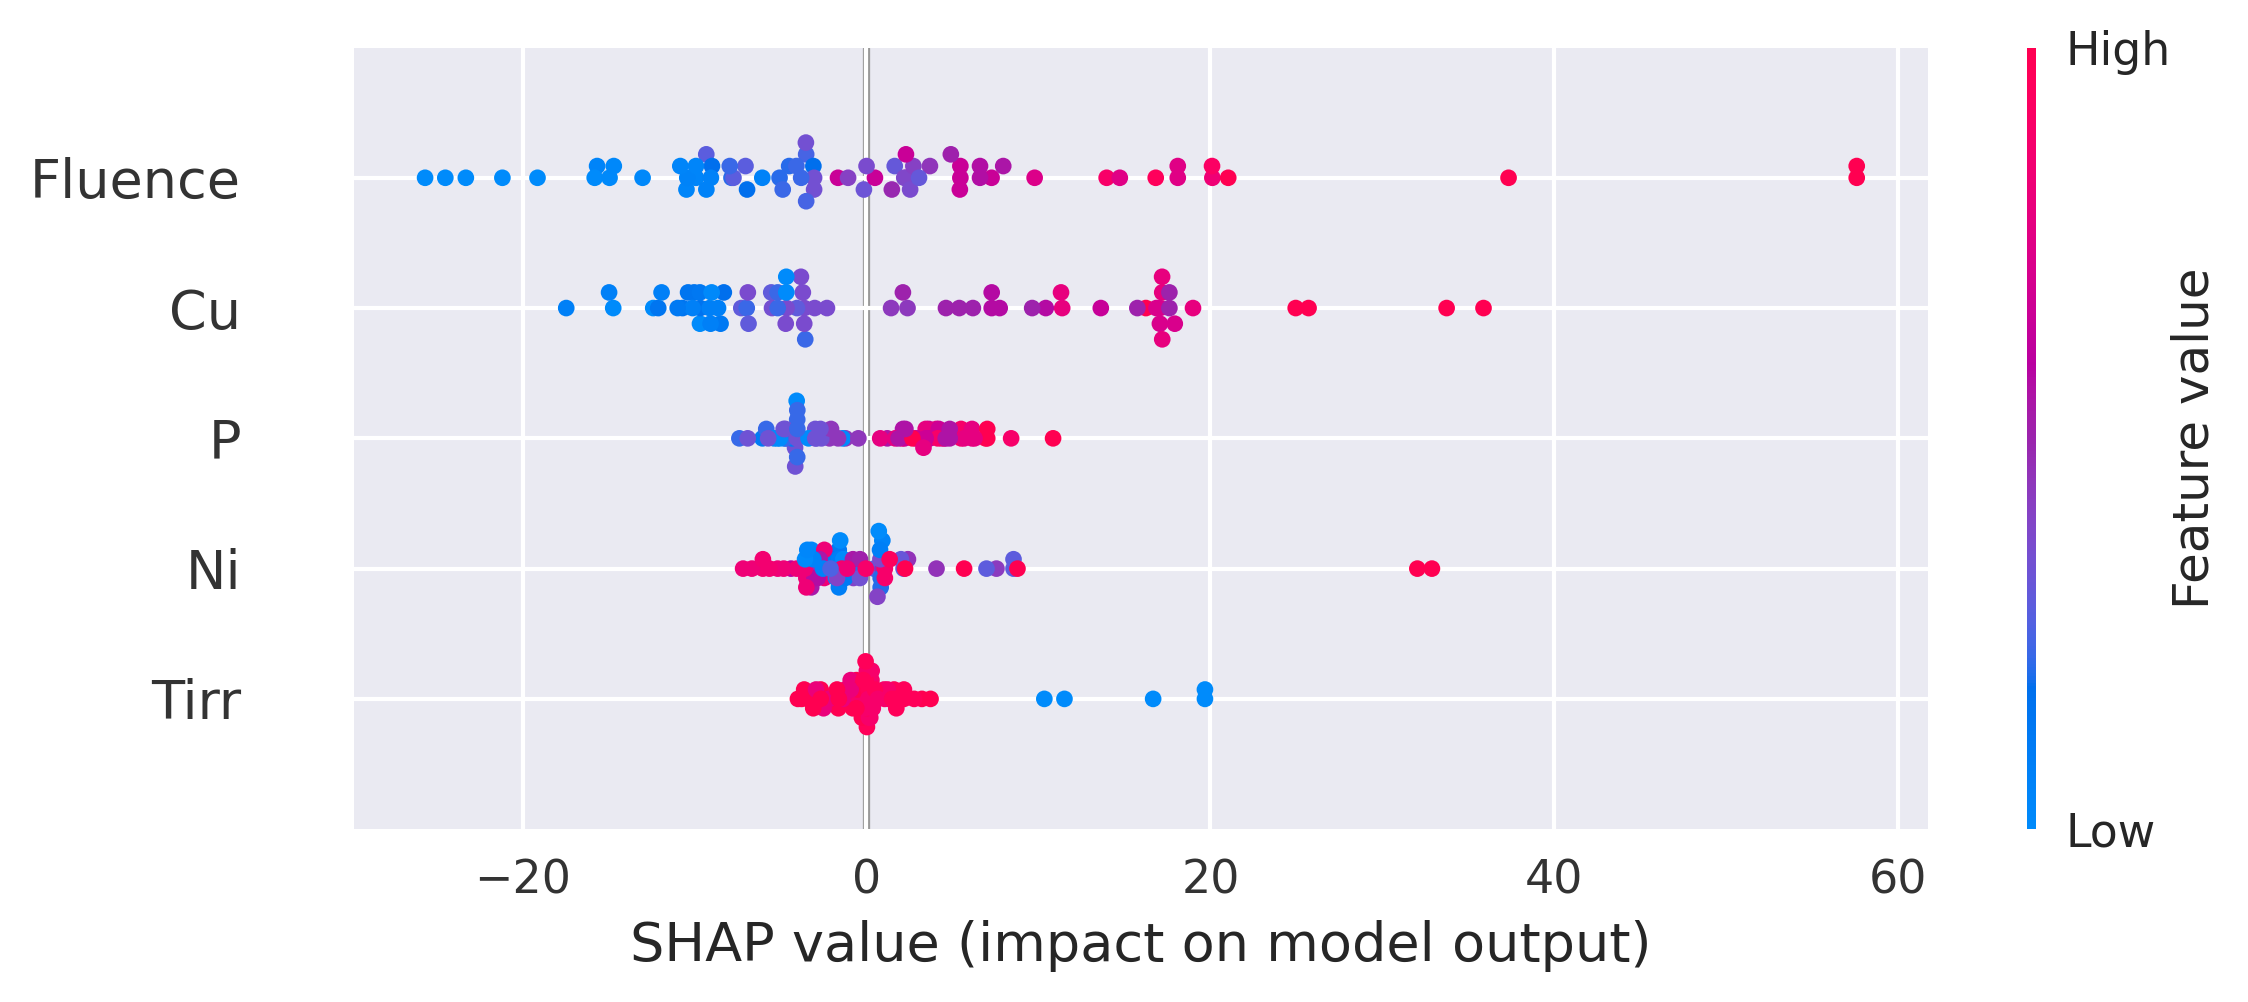

In [22]:
interpret_model(best_model, plot = 'summary')
